In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import  MultivariateNormal
from torch.autograd.functional import jacobian
from math import floor, ceil
from cmath import inf

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import os
import zipfile
import glob
import random
from PIL import Image
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# this block is for utility function
def load(path, model):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))

def gradlogp(h, mean, variance):
    return (mean - h)/variance

def div_gradlogp(variance):
    return -torch.sum(1/variance)



In [4]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim=32, nlayer=2):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.nlayer = nlayer
        self.w_in = nn.Linear(in_dim, hid_dim)
        self.w_out = nn.Linear(hid_dim, out_dim)
        self.w_hh = []
        for i in range(self.nlayer):
            self.w_hh.append(nn.Linear(hid_dim, hid_dim))


    def forward(self, input):
        input = torch.flatten(input)
        x = self.w_in(input)
        for i in range(self.nlayer):
            x = torch.tanh(x)
            x = self.w_hh[i](x)
        x = torch.tanh(x)
        return self.w_out(x)

In [38]:
import math


class LIF(torch.nn.Module):
    def __init__(self, in_dim, dt=0.001):
        super().__init__()
        self.dim = in_dim
        self.gamma = Parameter(torch.ones(in_dim, 1, requires_grad=True))
        self.W = nn.Linear(in_dim, in_dim, bias=False)
        # self.W_out = nn.Linear(in_dim, out_dim, bias = True)
        self.dt = dt

    def forward(self, input):
        v = self.cal_v(input)
        mean = torch.zeros(self.dim, device=device)+0.5
        var  = torch.ones(self.dim, device=device)/10
        v = gradlogp(input,mean, var)
        return input + self.dt*v + math.sqrt(2*self.dt)*torch.randn(self.dim, device=device)

    def cal_v(self, input):
        v = self.W(torch.tanh(input))
        v = v - torch.diag(self.W.weight)*torch.tanh(input)
        v = v - self.gamma.T*input
        return v


In [6]:
class RNN(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.w_in = nn.Linear(in_dim, hid_dim, bias=True)
        self.w_out = nn.Linear(hid_dim, out_dim, bias=True)
        self.w_hh = nn.Linear(hid_dim, hid_dim, bias=True)
    
    def forward(self,initial_state):
        #TODO add input here
        next = self.w_hh(initial_state)
        next = torch.tanh(next)
        return next

    # calculate the log determinant of the function at hidden_state
    def cal_logdet(self, hidden_state):
        batch_size = hidden_state.shape[0]
        hid_dim = hidden_state.shape[1]
        ans = torch.zeros(batch_size, 1).to(device)
        for i in range(batch_size):
            jac = jacobian(self.forward, hidden_state[i], create_graph=True) 
            ans[i] = torch.linalg.slogdet(jac)[1]
        return ans

In [7]:
# generate initial states that conforms to the Gaussian distribution
class GaussianData(Dataset):
    def __init__(self, mean = 0, variance = 1, n=1000, ndim=2):
        super().__init__()
        self.mean = mean
        self.variance = variance
        self.n = n
        self.ndim = ndim   

    def __len__(self) -> int:
        return self.n

    def __getitem__(self, index):
        return torch.empty(self.ndim).normal_(mean=self.mean,std=self.variance)

In [8]:
class UniformData(Dataset):
    def __init__(self, lower, upper, n=1000, ndim=2):
        super().__init__()
        self.ndim = ndim
        self.lower = lower
        self.upper = upper
        self.n = n

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        return torch.rand(self.ndim)*(self.upper-self.lower) + self.lower

In [30]:
in_dim, out_dim, hid_dim = 2,2,16
model = LIF(hid_dim).to(device)
# load("./model/best_model_mean_1.0_var0", model)
def train(model, loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)
    # m = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
    mean = torch.zeros(hid_dim, device=device)+0.1
    var  = torch.ones(hid_dim, device=device)
    min_loss = inf
    nepoch = 100
    for epoch in range(nepoch):
        for batchId, h in enumerate(loader):
            # print(batchId)
            h = h.to(device)
            div_f = div_gradlogp(var)
            f = gradlogp(h, mean, var)
            loss = 0.5*torch.norm(div_f + torch.inner(f, f) + torch.sum(model.gamma) - torch.inner(f, model.cal_v(h)))

            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if batchId % 100 == 0:
            #     print(f"loss: {loss.item():>7f}, batchId: {batchId}")
            if batchId % 10 == 0:
                if(loss.item()<min_loss):
                    torch.save(model.state_dict(), f"./model/best_model_mean_{mean[0].item()}_var{var[0].item():.1f}")
        print(f"loss: {loss.item():>7f}, Epoch: {epoch}")
data = UniformData(lower = -1., upper = 1., n=10000, ndim=hid_dim)
train_loader = torch.utils.data.DataLoader(data, batch_size= 32)
train(model, train_loader)

loss: 2.128223, Epoch: 0
loss: 1.785831, Epoch: 1
loss: 2.197350, Epoch: 2
loss: 1.913315, Epoch: 3
loss: 1.923787, Epoch: 4
loss: 1.744550, Epoch: 5
loss: 1.573852, Epoch: 6
loss: 1.757637, Epoch: 7
loss: 1.787382, Epoch: 8
loss: 1.753765, Epoch: 9
loss: 1.459354, Epoch: 10
loss: 1.638721, Epoch: 11
loss: 1.662323, Epoch: 12
loss: 1.743991, Epoch: 13
loss: 0.835251, Epoch: 14
loss: 2.029575, Epoch: 15
loss: 1.827068, Epoch: 16
loss: 1.637328, Epoch: 17
loss: 2.506869, Epoch: 18
loss: 1.890254, Epoch: 19
loss: 0.964287, Epoch: 20
loss: 1.627151, Epoch: 21
loss: 2.003679, Epoch: 22
loss: 1.275987, Epoch: 23
loss: 1.743683, Epoch: 24
loss: 1.557173, Epoch: 25
loss: 1.700076, Epoch: 26
loss: 1.355102, Epoch: 27
loss: 2.046829, Epoch: 28
loss: 1.628870, Epoch: 29
loss: 1.860333, Epoch: 30
loss: 1.347246, Epoch: 31
loss: 2.139622, Epoch: 32
loss: 2.570590, Epoch: 33
loss: 1.638433, Epoch: 34
loss: 1.603583, Epoch: 35
loss: 1.997357, Epoch: 36
loss: 2.395644, Epoch: 37
loss: 1.760796, Epoch:

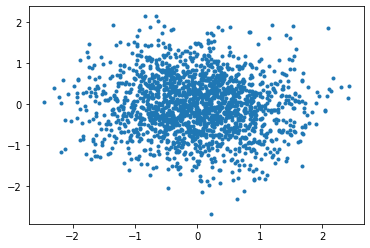

In [11]:
# now generate the trajectory of the trained RNN
model = LIF(hid_dim, 0.1).to(device)
load("./model/best_model_var0.5", model)
def gen_traj(model, initial_state, length):
    hidden_list = torch.zeros(length, model.dim)
    hidden_list[0] = initial_state
    next = initial_state
    for i in range(1, length):
        next = model(next)
        hidden_list[i] = next
    return hidden_list
# m = MultivariateNormal(torch.zeros(model.dim).to(device), torch.eye(model.dim).to(device))
# initial_state = m.sample().squeeze().to(device)
traj = gen_traj(model,torch.zeros(model.dim).to(device), 2000).detach().numpy()
plt.plot(traj[100:, 0], traj[100:, 1],'.')

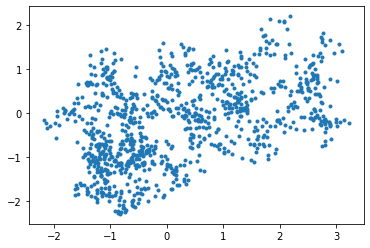

In [27]:
model = LIF(hid_dim, .01).to(device)
load("./model/best_model_mean_0.5_var0.5", model)
traj = gen_traj(model,torch.zeros(model.dim).to(device), 2000).detach().numpy()
plt.plot(traj[1000:, 0], traj[1000 :, 1],'.')

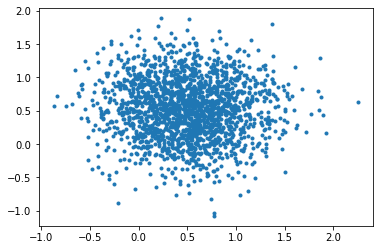

In [39]:
model = LIF(hid_dim, .1).to(device)
load("./model/best_model_var1.0", model)
traj = gen_traj(model,torch.zeros(model.dim).to(device), 2000).detach().numpy()
plt.plot(traj[100:, 0], traj[100 :, 1],'.')

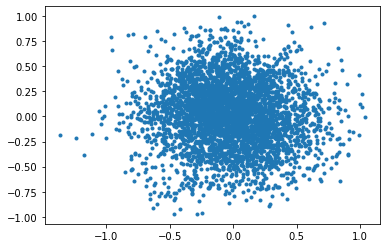

In [36]:
model = LIF(hid_dim, .01).to(device)
load("./model/best_model_var0.1", model)
traj = gen_traj(model,torch.zeros(model.dim).to(device), 5000).detach().numpy()
plt.plot(traj[1000:, 0], traj[1000:, 1],'.')

In [37]:
# np.var(np.random.normal(0, 1, 1000))
model.W.weight

Parameter containing:
tensor([[-2.0558e-02, -1.3405e-04, -4.7940e-04, -4.5900e-04,  1.3509e-03,
          5.0457e-04,  1.9640e-04,  6.7092e-04, -2.9364e-04, -1.1224e-03,
          9.8291e-05,  1.0749e-04, -5.5456e-04, -6.9945e-04,  1.6473e-04,
          5.6259e-04],
        [ 4.6082e-04, -3.1956e-02, -1.5012e-04,  3.0010e-04, -3.2321e-04,
          8.9272e-04, -4.5506e-04,  3.3259e-04,  2.1323e-04,  3.9487e-04,
          6.6563e-04, -1.8618e-04,  6.7263e-05,  5.5832e-04, -7.6607e-04,
         -1.7941e-04],
        [-1.4741e-03,  2.5161e-04,  2.6791e-02, -7.0547e-04,  1.3690e-03,
         -5.3050e-04,  5.4868e-04,  2.2946e-04,  5.6201e-04, -1.3618e-03,
         -8.1175e-04, -7.6970e-05, -2.6810e-04, -8.5610e-04,  8.2088e-04,
          9.3820e-04],
        [ 5.7352e-04, -1.3238e-04,  1.5841e-04, -1.9780e-02, -2.6343e-04,
          5.1310e-04, -3.5554e-04,  4.0774e-04, -4.7805e-04,  2.8975e-04,
          7.1403e-04,  9.0997e-04,  1.5423e-04,  1.3457e-04,  4.5453e-04,
          3.5003e-04]

In [20]:
in_dim, out_dim, hid_dim = 2,2,32
model = RNN(in_dim, out_dim, hid_dim).to(device)
load("./model/best_model", model)
def train(model, loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)
    m = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
    loss_fun = torch.nn.MSELoss()
    min_loss = inf
    nepoch = 10
    for epoch in range(nepoch):
        for batchId, h in enumerate(train_loader):
            # print(batchId)
            h = h.to(device)
            logdet = model.cal_logdet(h)
            gh = model.w_out(model(h))
            h = model.w_out(h)
            logph = m.log_prob(h).reshape([32,1])
            logpgh = m.log_prob(gh).reshape([32,1])
            loss = loss_fun(-logpgh + logph, logdet)

            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batchId % 100 == 0:
                print(f"loss: {loss.item():>7f}, batchId: {batchId}")
            if batchId % 10 == 0:
                if(loss.item()<min_loss):
                    torch.save(model.state_dict(), f"./model/best_model")
        print(f"loss: {loss.item():>7f}, Epoch: {epoch}")
mean = torch.tensor([0.]).to(device)
variance = torch.tensor([1.]).to(device)
data = GaussianData(mean.item(), variance.item(), n = 60000, ndim = 32)
train_loader = torch.utils.data.DataLoader(data, batch_size=32)
train(model, train_loader)


        

loss: 247.722046, batchId: 0


KeyboardInterrupt: 

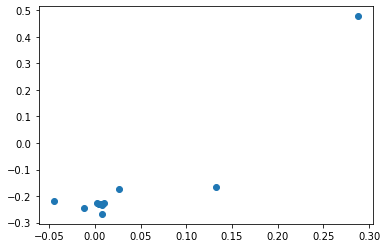

In [22]:
# now generate the trajectory of the trained RNN
def gen_traj(model, initial_state, length):
    hidden_list = torch.zeros(length, model.out_dim)
    hidden_list[0] = model.w_out(initial_state)
    next = initial_state
    for i in range(1, length):
        next = torch.tanh(model.w_hh(next))
        hidden_list[i] = model.w_out(next)
    return hidden_list
rawRNN = RNN(in_dim, out_dim, hid_dim).to(device)
m = MultivariateNormal(torch.zeros(32).to(device), torch.eye(32).to(device))
initial_state = m.sample().squeeze().to(device)
traj = gen_traj(rawRNN,initial_state, 10000).detach().numpy()
plt.plot(traj[:, 0], traj[:, 1],'o')
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])


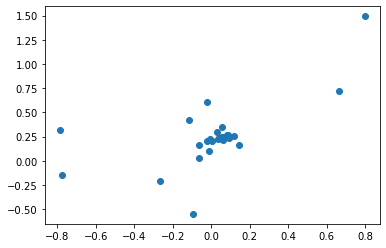

In [21]:
m = MultivariateNormal(torch.zeros(32).to(device), torch.eye(32).to(device))
initial_state = m.sample().squeeze().to(device)
traj = gen_traj(model,initial_state, 10000).detach().numpy()
plt.plot(traj[:, 0], traj[:, 1],'o')
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])


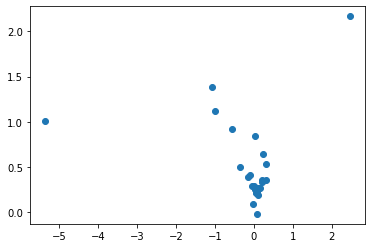

In [27]:
m = MultivariateNormal(torch.zeros(32).to(device), torch.eye(32).to(device))
initial_state = m.sample().squeeze().to(device)
traj = gen_traj(model,initial_state, 10000).detach().numpy()
plt.plot(traj[:, 0], traj[:, 1],'o')